## Setup Environment

In [ ]:
!pip install -q transformers torch seaborn tqdm

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import ast

##  Load Dataset & Model Indobert

In [ ]:
# Ganti path sesuai lokasi file kamu di Colab / Drive
df = pd.read_csv("/content/jaklingko_text_final.csv")

MODEL_NAME = "cahya/bert-base-indonesian-NER"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

ner_pipeline = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

print(f"✅ Model NER IndoBERT '{MODEL_NAME}' berhasil dimuat.")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 9863c197-74ee-4c66-b103-fa60555d7968)')' thrown while requesting HEAD https://huggingface.co/cahya/bert-base-indonesian-NER/resolve/main/model.safetensors.index.json
Retrying in 1s [Retry 1/5].


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at cahya/bert-base-indonesian-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Model NER IndoBERT 'cahya/bert-base-indonesian-NER' berhasil dimuat.


## NER (Named Entity Recognition)

In [ ]:
def run_ner(text):
    """Ekstraksi entitas dari teks menggunakan IndoBERT."""
    if not isinstance(text, str) or pd.isna(text):
        return []
    try:
        entities = ner_pipeline(text)
        formatted = [{"entity": e["word"], "label": e["entity_group"]} for e in entities]
        return formatted
    except Exception as e:
        print(f"⚠️ Error on text: {e}")
        return []

print("🚀 Memulai proses NER...")
df["Entitas_NER_Raw"] = df["cleaned_text"].apply(run_ner)
print("✅ Proses NER selesai.")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🚀 Memulai proses NER...
⚠️ Error on text: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (543) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (615) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (824) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (644) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (766) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (792) must match the size of tensor b (512) at non-singleton dimension 1
⚠️ Error on text: The size of tensor a (587) must match the size of tensor b (51

## Post-Processing NER

In [ ]:
def merge_jaklingko_variants(word):
    word = word.lower().strip()
    if re.search(r'\bjak(\s+)?(ling|lingko|lingko)?\b', word):
        return "jaklingko"
    return word

def clean_entity_text(word):
    """Perbaiki token dan hapus noise umum"""
    w = word.lower().strip()
    w = re.sub(r'(wartakotalive|kompas|detik|tribun|onlineting|co id|co)', '', w)
    w = re.sub(r'[^a-z\s]', '', w)
    w = re.sub(r'(jak\s+)+', 'jak ', w)
    return w.strip()

print("🧹 Membersihkan dan menormalkan entitas...")

entities_by_label = defaultdict(lambda: defaultdict(int))
for _, row in df.iterrows():
    for ent in row["Entitas_NER_Raw"]:
        label = ent.get("label")
        word = ent.get("entity")
        if label and word:
            cleaned_word = clean_entity_text(merge_jaklingko_variants(word))
            if len(cleaned_word) > 2:
                entities_by_label[label][cleaned_word] += 1

print("✅ Cleaning tahap 1 selesai.")


🧹 Membersihkan dan menormalkan entitas...
✅ Cleaning tahap 1 selesai.


## Relabel & Noise Removal

In [ ]:
# Gabungkan entitas transportasi PRD/NOR ke ORG
relabeled_keywords = {"jaklingko", "transjakarta", "lrt", "mrt", "mikrotrans"}

for label in list(entities_by_label.keys()):
    cleaned_counts = defaultdict(int)
    for word, freq in entities_by_label[label].items():
        if word in {"rin", "mikro", "first", "selasa", "sach"}:
            continue
        if (label in {"PRD", "NOR"}) or any(k in word for k in relabeled_keywords):
            entities_by_label["ORG"][word] += freq
        else:
            cleaned_counts[word] += freq
    entities_by_label[label] = cleaned_counts

for lbl in ["PRD", "NOR"]:
    if lbl in entities_by_label:
        del entities_by_label[lbl]

print("✅ Subword merge dan relabel selesai.")


✅ Subword merge dan relabel selesai.


## NER Summary & Visualization

In [ ]:
output_rows = []
sorted_labels = sorted(
    entities_by_label.keys(),
    key=lambda k: sum(entities_by_label[k].values()),
    reverse=True
)

for label in sorted_labels:
    top_words = Counter(entities_by_label[label]).most_common(10)
    word_str = "; ".join([f"{w} ({f})" for w, f in top_words])
    output_rows.append({
        "Entity Label": label,
        "Total Frequency": sum(entities_by_label[label].values()),
        "Top 10 Kata (Frekuensi)": word_str
    })

df_entity_summary = pd.DataFrame(output_rows)
display(df_entity_summary)

# Simpan ke file
df_entity_summary.to_excel("ner_entity_summary_jaklingko_final.xlsx", index=False)
print("💾 Hasil disimpan: ner_entity_summary_jaklingko_final.xlsx")


,Entity Label,Total Frequency,Top 10 Kata (Frekuensi)
0,ORG,3308,jaklingko (444); trans (105); ling (90); trans...
1,PER,726,pram (32); pramono (29); heru (29); kevin (26)...
2,GPE,588,jakarta (324); dki (35); bekasi (26); tangeran...
3,LOC,366,stasiun (13); pasar (12); terminal (10); ragu ...
4,EVT,161,agustus (6); hari (5); lingko (4); persen (3);...
5,DAT,138,senin (22); rabu (18); jumat (14); minggu (12)...
6,CRD,123,satu (52); dua (22); empat (17); delapan (8); ...
7,FAC,33,terminal (7); bandara (3); halte (2); rsud cen...
8,ORD,22,pertama (14); kedua (5); keempat (2); ketiga (1)
9,LAW,14,apbd (5); peraturan (3); skema (1); service ob...


💾 Hasil disimpan: ner_entity_summary_jaklingko_final.xlsx


/tmp/ipython-input-458280682.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


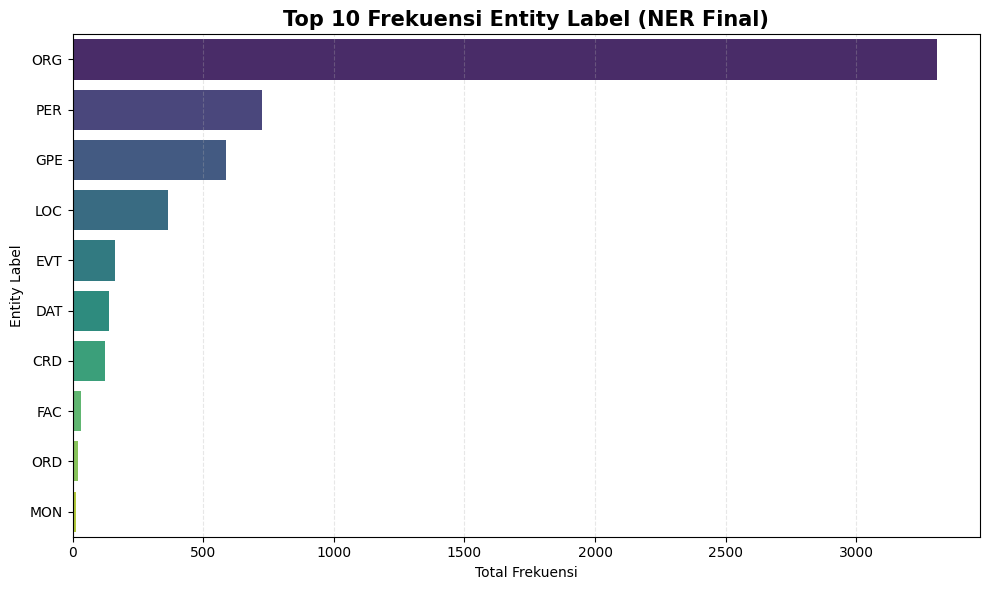

In [ ]:
entity_freq = pd.DataFrame([
    {"Entity Label": label, "Total Frequency": sum(entities_by_label[label].values())}
    for label in entities_by_label
]).sort_values("Total Frequency", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    data=entity_freq.head(10),
    x="Total Frequency",
    y="Entity Label",
    palette="viridis"
)
plt.title("Top 10 Frekuensi Entity Label (NER Final)", fontsize=15, weight="bold")
plt.xlabel("Total Frekuensi")
plt.ylabel("Entity Label")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
